# Narrowband Energy Detection from Wideband Signal

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns
import math
sns.set()

In [52]:
# Signal Generator Parameters:
freq = 1000.0 # Hz
duration = 1.5 # seconds
oversamp = 10 # oversampling rate
Fs = freq*oversamp # samples per second
AWGN_SNR = 0.0 # dB

NOTE: **Additive White Gaussian Noise (AWGN)** is sampled from a normal distribution with ${\mu} = 0$ and ${\sigma}^2 = 10^\frac{-SNR}{10}$ ([ref](https://www.sharetechnote.com/html/Handbook_Communication_awgn.html))

For complex-valued noise, need to scale ${\sigma}^2$ by $\frac{1}{2}$ (i.e., scale RMS noise power by $\frac{\sqrt{2}}{2}$)

In [33]:
def sig_gen(freq, duration, Fs, AWGN_SNR=None, complex=True):
    '''
    Synthesizes a sinusoidal signal (with optional noise)
    
    freq = sinusoid frequency (in Hz)
    duration = duration of synthesized signal (in seconds)
    Fs = sample frequency (in samples per second)
    AWGN_SNR = signal-to-noise ratio for gaussian noise (in dB)
    complex = return complex samples? (boolean)
    '''
    if freq is None: # no tone present, just noise
        sig = 0.0
        freq = 0.0
    else:
        sig = 1.0
        
    omega = 2*np.pi*freq
    t = np.linspace(0,duration, int(duration*Fs))
    
    if AWGN_SNR is not None:
        variance = np.power(10, -AWGN_SNR/10)
        # Additive White Gaussian Noise
        # Create gaussian white noise signal:
        if complex:
            variance = variance/2
            awgn = np.sqrt(variance)*(np.random.randn(int(duration*Fs)) + 1j*np.random.randn(int(duration*Fs)))
            return sig*np.exp(-1j*(omega*t)) + awgn
        else:
            awgn = np.random.normal(0, np.sqrt(variance), int(duration*Fs))
            return sig*np.real(np.exp(-1j*(omega*t))) + awgn

In [163]:
def psd_plot(signal, NFFT=1024, width=16, Fs=None):
    # TODO: optimize for performance
    if NFFT%2 != 0:
        NFFT = NFFT+1
    i=0
    if len(signal)%NFFT != 0:
        signal = signal[:-(len(signal)%NFFT)] # discard extra data that can't be used
    if Fs == None:
        Fs = 1.0
#     #reps = int(len(signal)/NFFT)
#     f_output = np.tile(np.fft.fftshift(np.fft.fftfreq(n=NFFT, d=1/Fs)), int(len(signal)/NFFT))
    #f_output = np.zeros(int(len(signal)))
    coeff_output = np.zeros(int(len(signal)), dtype=np.complex128)
    while i < len(signal):
        coeff_output[i:i+NFFT] = np.fft.fftshift(np.fft.fft(signal[i:i+NFFT]))
        i += NFFT
#    freq_data = f_output.reshape((int(np.floor(len(f_output)/NFFT)), NFFT))
    freqs = np.fft.fftshift(np.fft.fftfreq(n=NFFT, d=1/Fs))
    coeff_data = coeff_output.reshape((int(np.floor(len(coeff_output)/NFFT)), NFFT))
    # square the coefficient magnitudes:
    squared = np.square(np.absolute(coeff_data))
    # normalize by highest value in each fft, compute in dB:
    normalized_db = 10*np.log10(squared/np.amax(squared))
    # plot:
    if coeff_data.shape[0]*16//300 == 0.0:
        assert False, "Not enough data to plot! Try inputting a longer signal."
    fig, ax = plt.subplots(figsize=(width, coeff_data.shape[0]*16//300))
    ax.grid(False)
    ax.imshow(normalized_db)

    # Scale tick on x-axis according to appropriate frequencies
    ax.set_xticks(np.arange(0, NFFT + NFFT/8, NFFT/8))
    print(len(ax.get_xticklabels()))
    print(ax.get_xticklabels())
    n = len(ax.get_xticklabels()) - 1
    frange = max(freqs) - min(freqs)
    print(frange)
    step = frange/n
    print(step)
    xlabels = []
    i = min(freqs)
    for label in ax.get_xticklabels():
        xlabels.append(to_precision(i, 4))
        i = i + step
    ax.set_xticklabels(xlabels)
    ax.set_xlabel("Frequency (Hz)")

    # Scale ticks on y-axis according to time in seconds
    n = len(ax.get_yticklabels()) - 2
    step = coeff_data.shape[0] * (NFFT/Fs) / n        
    ylabels = ['']
    i = 0
    for label in ax.get_yticklabels():
        ylabels.append(to_precision(i, 3))
        i = i + step
    ax.set_yticklabels(ylabels)
    ax.set_ylabel("Time (s)")
#    return fig, ax
    return freqs, coeff_data

In [165]:
if coeff_data.shape[0] > 10:
    

(117, 512)

9
[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]
5988.28125
748.53515625


/home/derek/python-venvs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


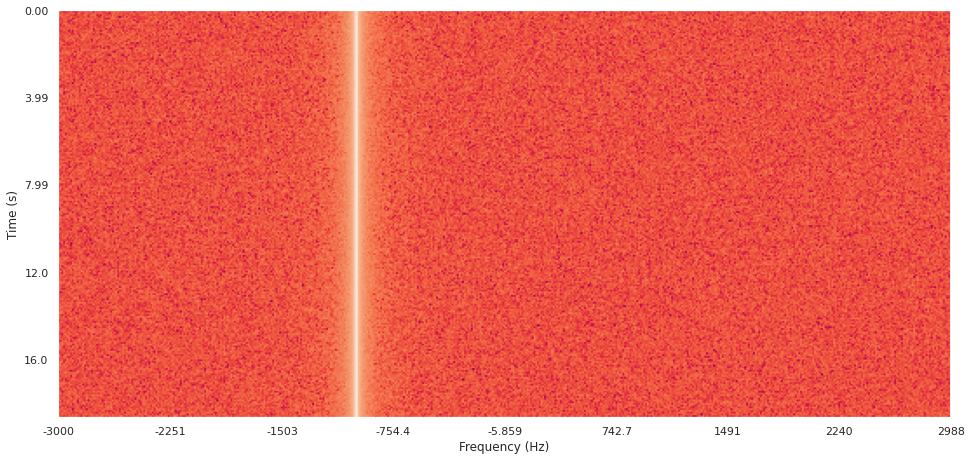

In [167]:
duration = 20.0
freq = 1000
Fs = 6000
my_signal = sig_gen(freq, duration, Fs, AWGN_SNR=10.0, complex=True)
f, c = psd_plot(my_signal, Fs=Fs, NFFT=512, width=16)

In [38]:
# Create and on-off-keying (OOK) signal:
freq = 3000.0
Fs = 10*freq
AWGN_SNR = 0.0

noise_duration = 0.5
burst_duration = 0.25

my_signal = np.concatenate([sig_gen(None, 3*noise_duration, Fs, AWGN_SNR),
                            sig_gen(freq, burst_duration, Fs, AWGN_SNR),
                            sig_gen(None, noise_duration, Fs, AWGN_SNR),
                            sig_gen(freq, burst_duration, Fs, AWGN_SNR),
                            sig_gen(None, noise_duration, Fs, AWGN_SNR),
                            sig_gen(freq, burst_duration, Fs, AWGN_SNR),
                            sig_gen(None, 3*noise_duration, Fs, AWGN_SNR)])

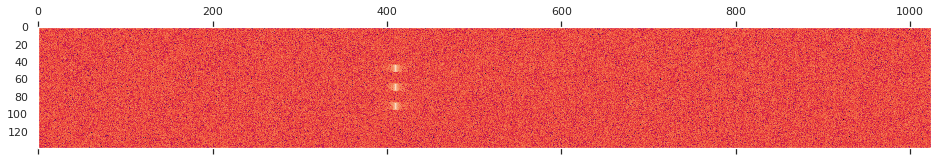

In [39]:
temp = psd_plot(my_signal)

In [ ]:
def compare_threshold(window, threshold, freq_range):
    '''
    returns a list of NB energy detections within the given signal window, based on the threshold given
    
    '''
    # TODO: Compute FFT of the given signal window
    
    # TODO: Determine which (if any) FFT coefficients' magnitude exceeds threshold
    
    # TODO: Return a list of FFT bins exceeding energy threshold (use freq_range data
    #       to determine which freq bands (in Hz) have energy)

In [ ]:
def run_energy_detection(signal):
    '''
    runs energy detection routine on the wideband signal given
    '''
    # TODO: determine appropriate window size
    
    # TODO: loop through each window, compute a running detection threshold (maybe?),
    #       and run "compare_threshold()" to determine if any energy present
    
    # TODO: return up/down times for each energy detection event (i.e., burst)

Additional notes:
+ Need to research what the best way to determine the energy detection threshold is (running average, maybe?)--there are probably a number of different ways
+ Figure out how to determine which FFT bin the energy is centered on (you can see in the plot that multiple continguous horizontal pixels are brighter than the rest of the noise--which one is the brightest?)
+ Figure out how to map FFT coefficients (i.e., FFT bins) to actual frequency values (those bursts in the plot are centered at 3 kHz) 
+ Figure out the best way to run the whole signal through and determine up/down times for burst events

In [63]:
def to_precision(x,p):
    """
    returns a string representation of x formatted with a precision of p
    
    lifted from: http://randlet.com/blog/python-significant-figures-format/

    Based on the webkit javascript implementation taken from here:
    https://code.google.com/p/webkit-mirror/source/browse/JavaScriptCore/kjs/number_object.cpp
    """

    x = float(x)

    if x == 0.:
        return "0." + "0"*(p-1)

    out = []

    if x < 0:
        out.append("-")
        x = -x

    e = int(math.log10(x))
    tens = math.pow(10, e - p + 1)
    n = math.floor(x/tens)

    if n < math.pow(10, p - 1):
        e = e -1
        tens = math.pow(10, e - p+1)
        n = math.floor(x / tens)

    if abs((n + 1.) * tens - x) <= abs(n * tens -x):
        n = n + 1

    if n >= math.pow(10,p):
        n = n / 10.
        e = e + 1

    m = "%.*g" % (p, n)

    if e < -2 or e >= p:
        out.append(m[0])
        if p > 1:
            out.append(".")
            out.extend(m[1:p])
        out.append('e')
        if e > 0:
            out.append("+")
        out.append(str(e))
    elif e == (p -1):
        out.append(m)
    elif e >= 0:
        out.append(m[:e+1])
        if e+1 < len(m):
            out.append(".")
            out.extend(m[e+1:])
    else:
        out.append("0.")
        out.extend(["0"]*-(e+1))
        out.append(m)

    return "".join(out)